## Visualize model outputs

#### Disabling Jupyter's inline scroll option

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

#### Importing equired importing libraries

In [2]:
import os
import tensorflow as tf
from scripts.model_result_scripts import read_inputs_report, read_model_inputs, read_model, get_metrics_log, get_timekeeper
from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib
from IPython.display import Image

%matplotlib inline

#### Reading Model configuration and Input files
Set ```model_outputs_path``` output root folder of model outputs

In [3]:
model_outputs_path = "/home/nagellette/Desktop/model_outputs/"
ran_models = os.listdir(model_outputs_path)
ran_models.sort()
for index, folder in enumerate(ran_models):
    print("{}: {}".format(index + 1, folder))

chosen_index = int(input())
chosen_model = ran_models[chosen_index - 1]
working_path = "{}{}/".format(model_outputs_path, chosen_model)

clear_output()

root_file_list, image_file_list, model_type = read_inputs_report(working_path)
image_file_list.sort()
model_config, image_file_names = read_model_inputs(working_path)
time_log = get_timekeeper(working_path)

Working path: /home/nagellette/Desktop/model_outputs/dlinknet_2021_01_26-01_04_05/
Model in use: dlinknet
# available test images: 195
File in use: /home/nagellette/Desktop/model_outputs/dlinknet_2021_01_26-01_04_05/config.json
File in use: /home/nagellette/Desktop/model_outputs/dlinknet_2021_01_26-01_04_05/inputs.json

Model configuration:
Batch size: 1
Patch size: (512, 512)
Optimizer: SGD
Learning rate: 0.0001
Decay: 1e-05
Momentum: 0.9
Nesterov: True
# of epochs: 20
Train, Test, Validation split: 0.6, 0.2, 0.2
Rotation augmentation: 45
Patch overlap ratio: 0.2
Shuffle outputs: True
Seeding: 10
# training steps per epoch: 50
Model tested?: True
Model test size: 20
Model validation size: 5
Loss function: dice
Input files and standardization method:
File: montreal_20160720_B02_small.tif, Standardization: sentinel_msi
File: montreal_20160720_B03_small.tif, Standardization: sentinel_msi
File: montreal_20160720_B04_small.tif, Standardization: sentinel_msi
Training iterations   - Mean: 12

#### Model Architecture:

Total parameters: 46144834
Trainable Parameters: 46118914
Non-trainable parameters: 25920


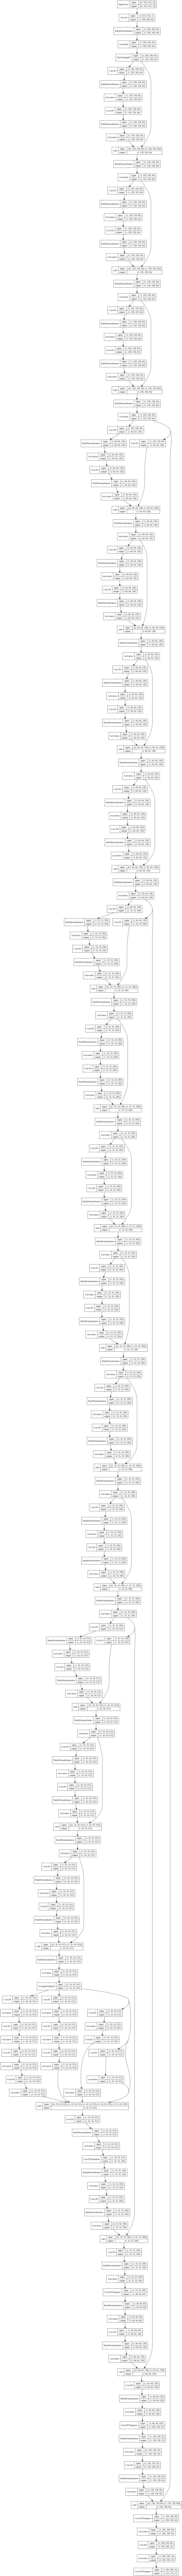

In [4]:
model = read_model(working_path)

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Model performance graphs

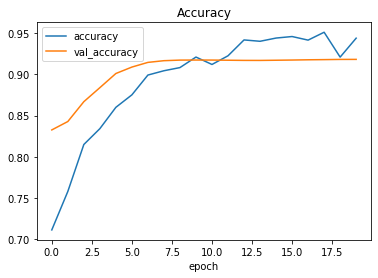

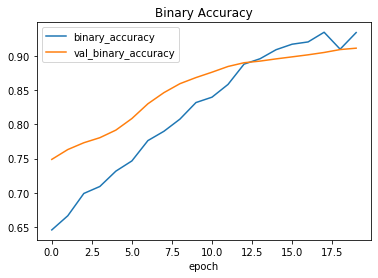

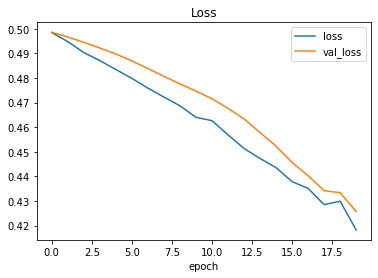

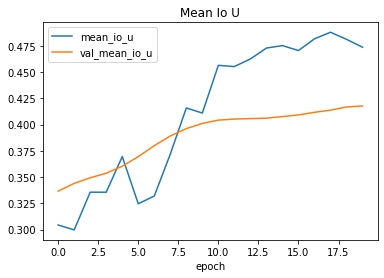

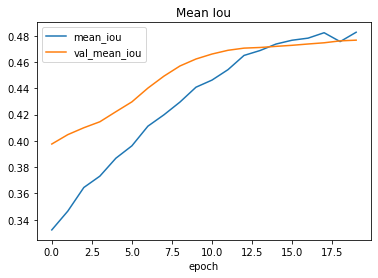

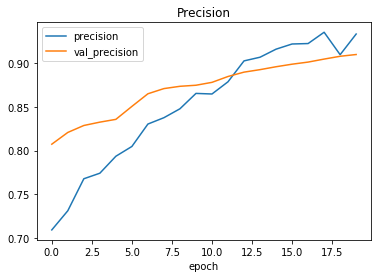

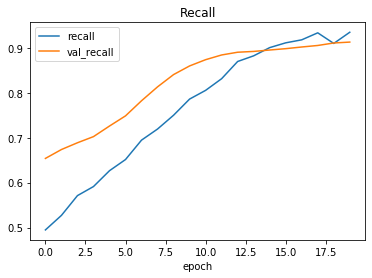

In [5]:
log = get_metrics_log(working_path)
columns = log.columns
metrics =[x.replace("val_", "") for x in columns if "val" in x]
for metric in metrics:
    log_temp = log[["epoch", metric, "val_" + metric]]
    plot = log_temp.set_index("epoch").plot(title=metric.title().replace("_", " "))

#### Process input files to avoid the ones that have data but not prediction

In [6]:
limit = 0
traj_available = False
speed_max_available = False
speed_avg_available = False

subgraph_count = 3

for i in range(len(image_file_list)):
    for file in image_file_list:
        if "traj_count" in file:
            if not traj_available:
                subgraph_count += 1
            traj_available = True
            
        if "speed_max" in file:
            if not speed_max_available:
                subgraph_count += 1
            speed_max_available = True
            
        if "speed_avg" in file:
            if not speed_avg_available:
                subgraph_count += 1
            speed_avg_available = True
            
        if file.startswith("{}_".format(str(i))) and "predict" in file:
            limit += 1
            break
            
width_ratio = []
for i in range(subgraph_count):
    width_ratio.append(10)

print("Trajectory count             : {}".format(traj_available))            
print("Speed max                    : {}".format(speed_max_available))            
print("Speed avg                    : {}".format(speed_avg_available))            
print("Number of prediction examples: {}".format(limit))

Trajectory count             : False
Speed max                    : False
Speed avg                    : False
Number of prediction examples: 20


#### Read predictions, labels and Sentinel RGB images.
- ```threshold```set to 0.5, change if required.
- Known issues:
    - Sentinel RGB image seems false color due to preprocessing.


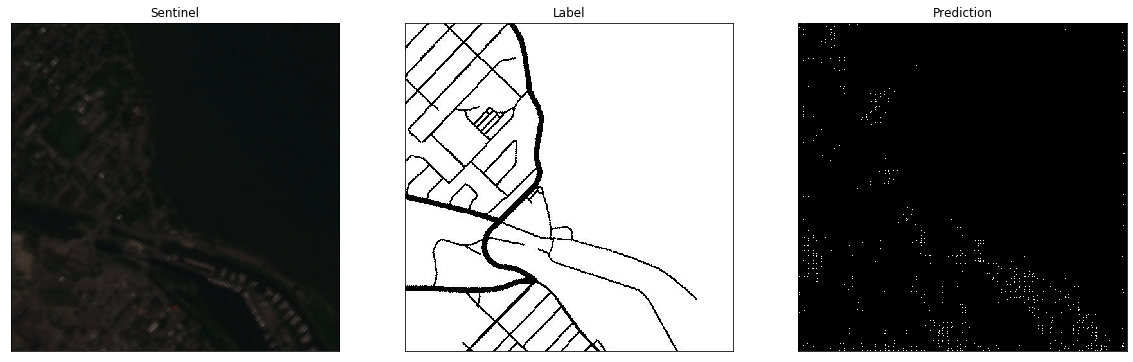

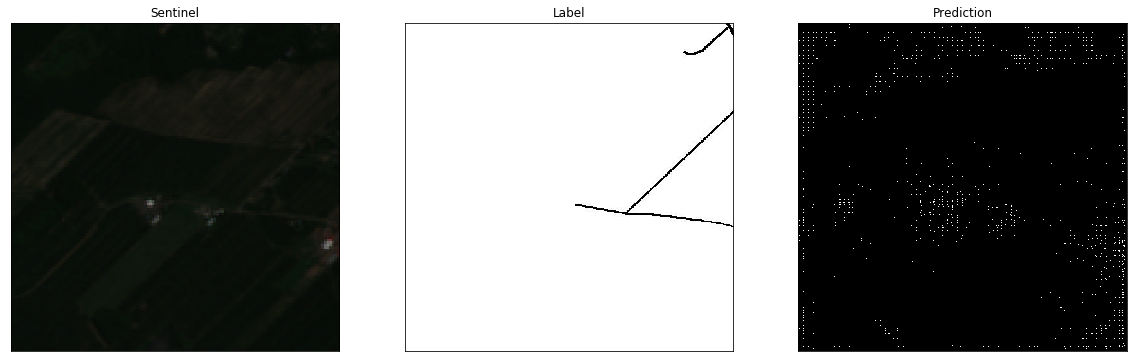

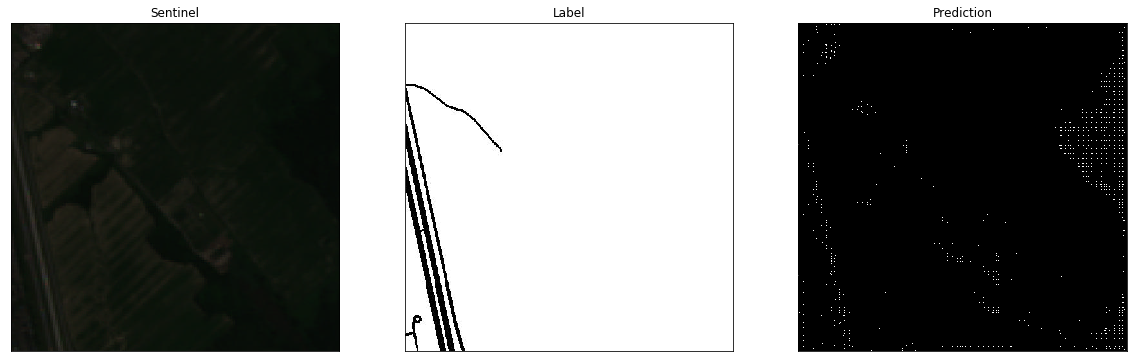

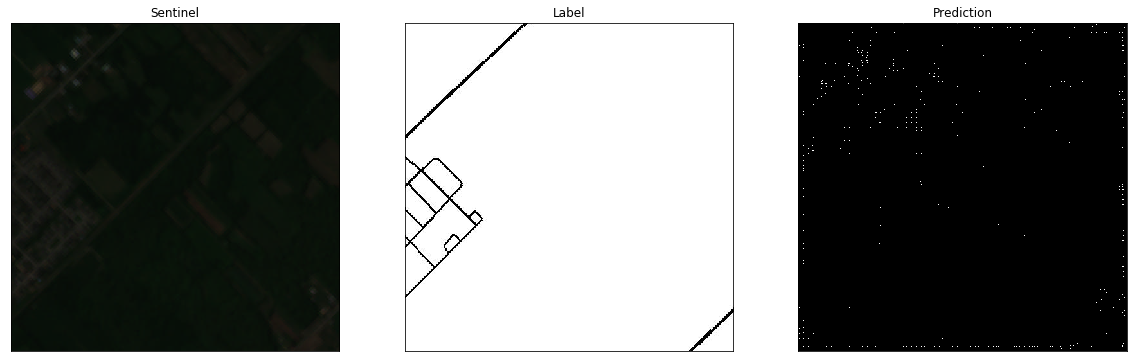

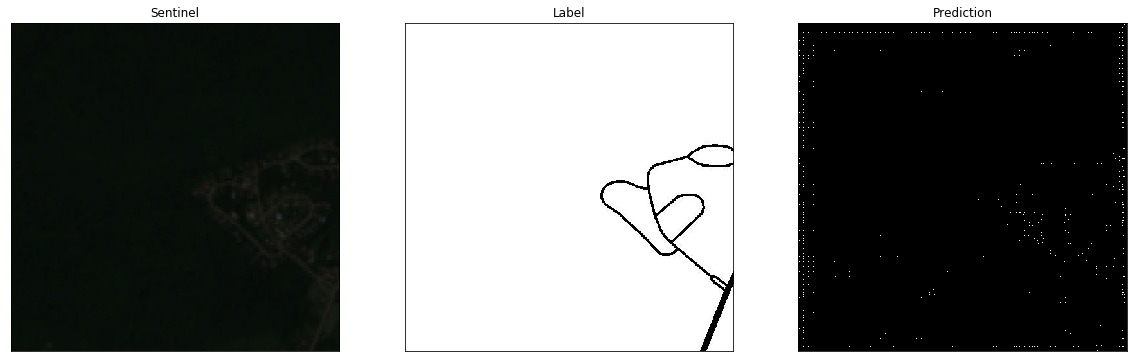

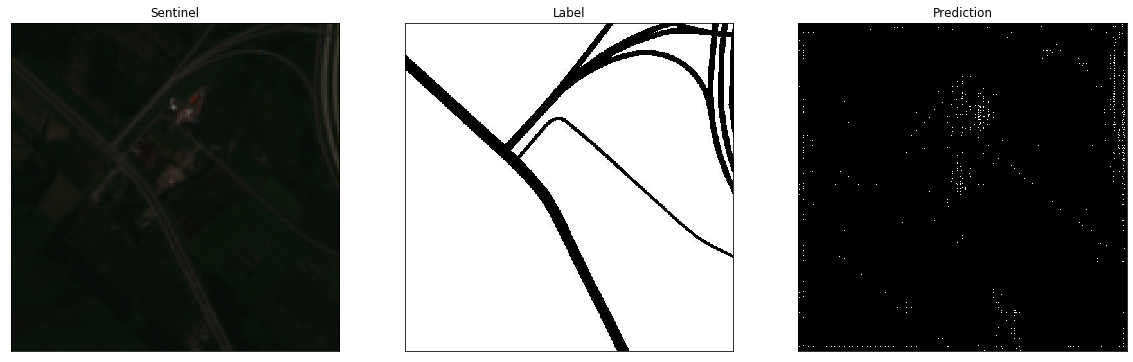

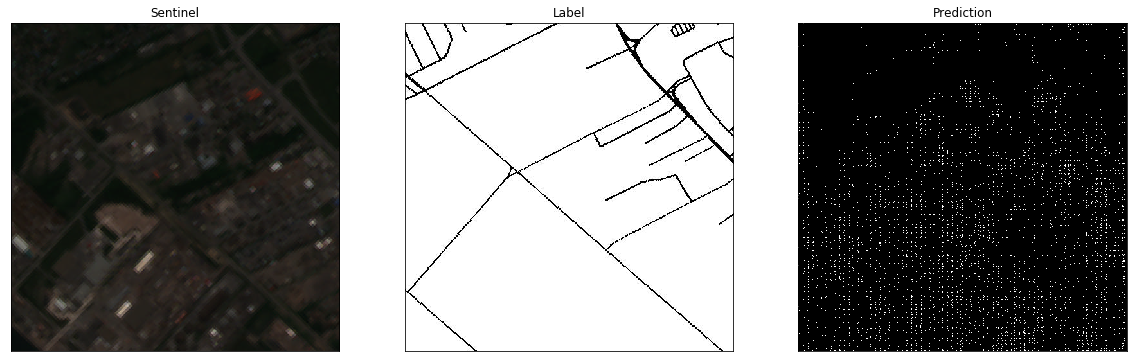

Label image patch doesn't contain any road.


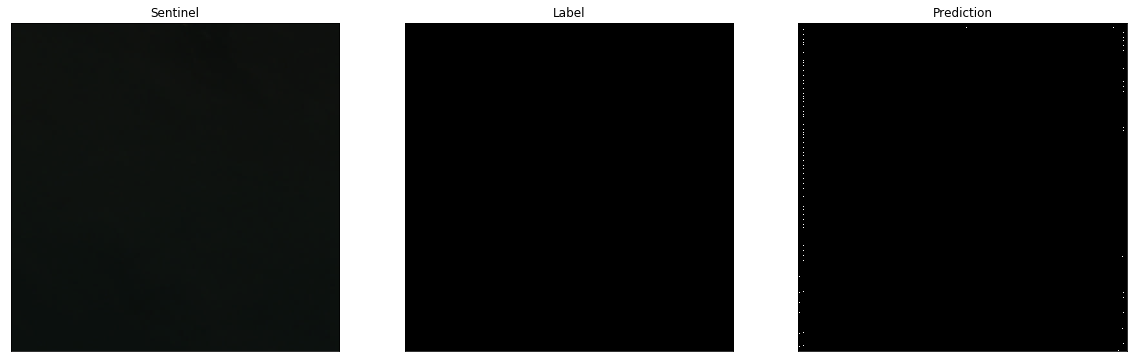

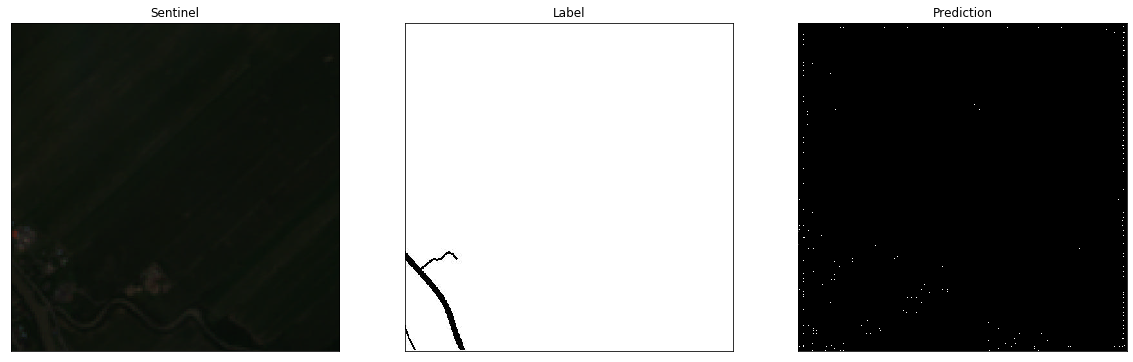

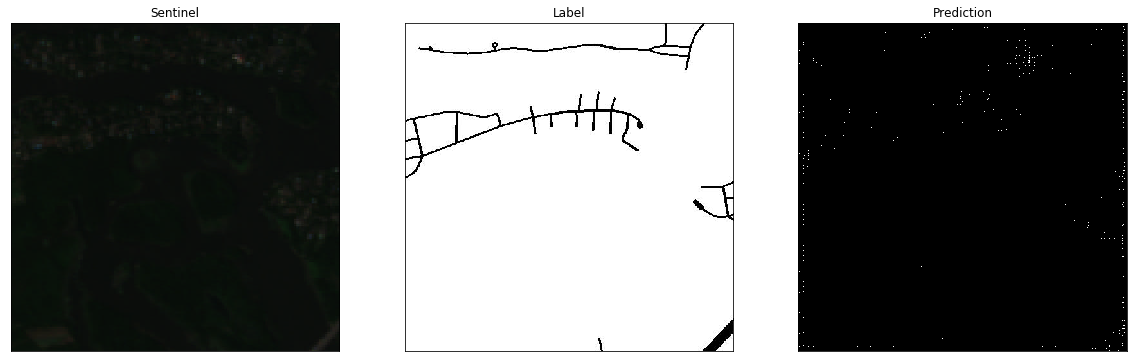

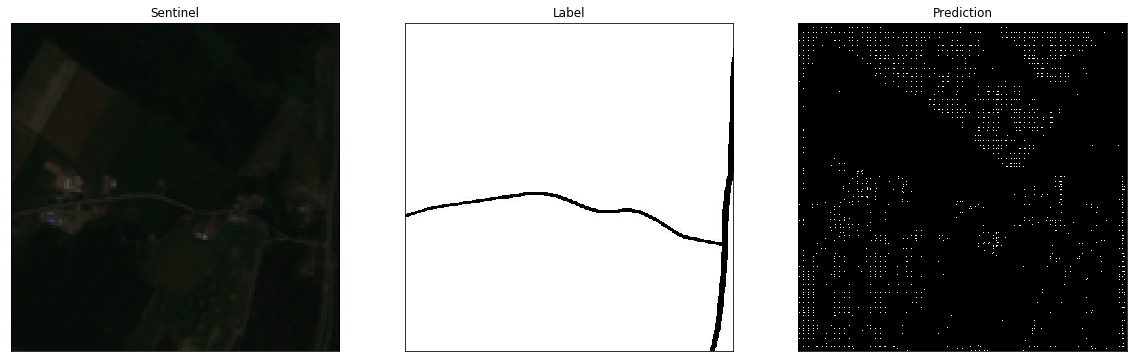

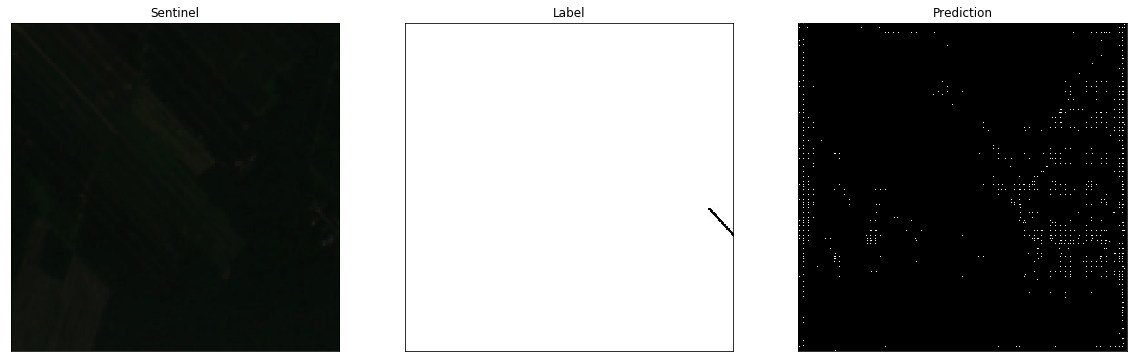

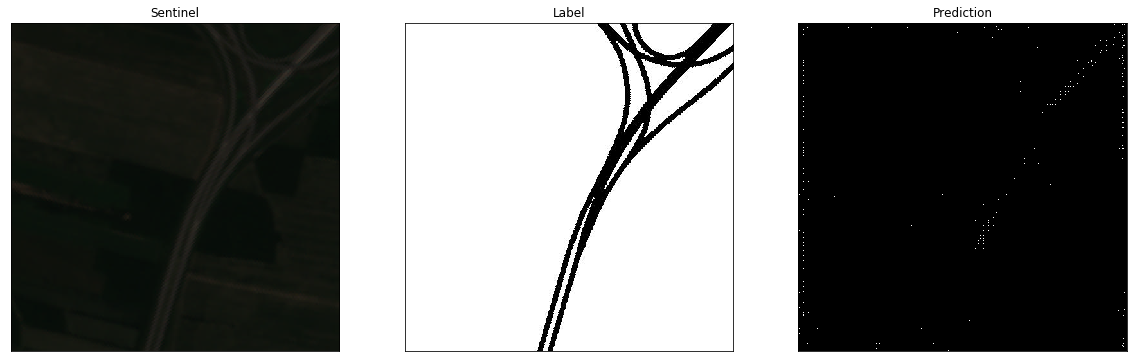

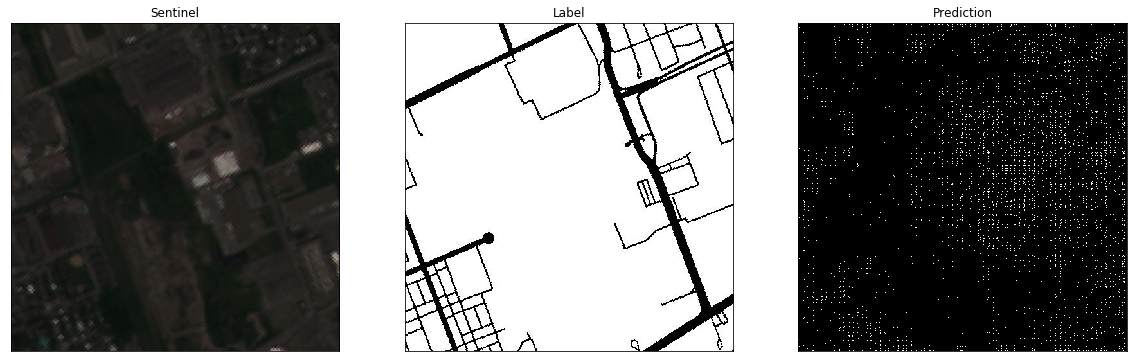

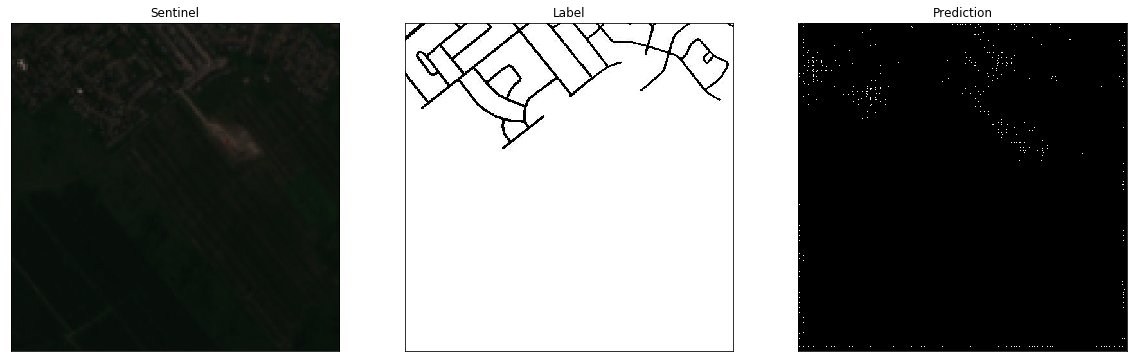

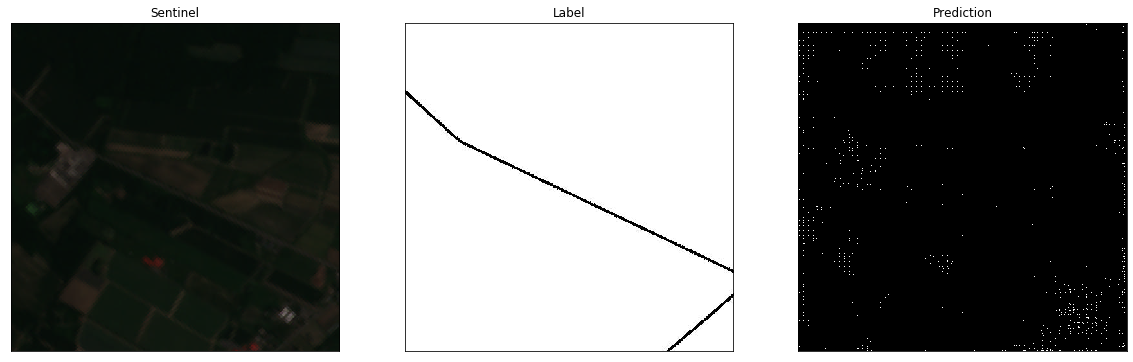

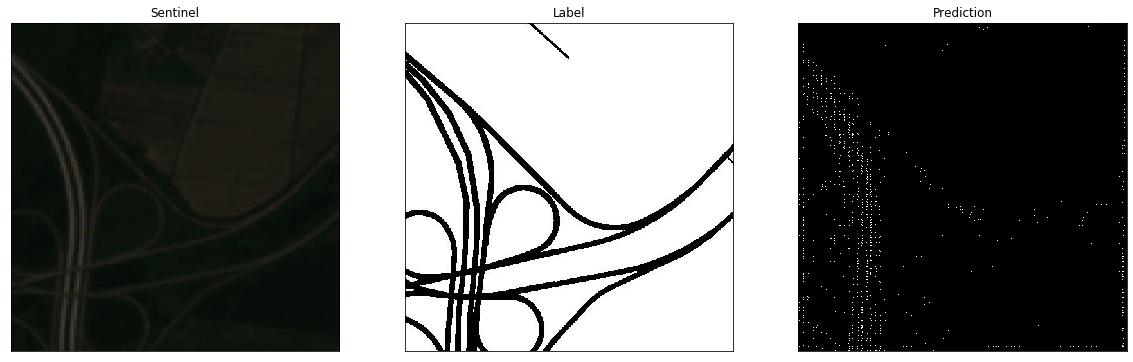

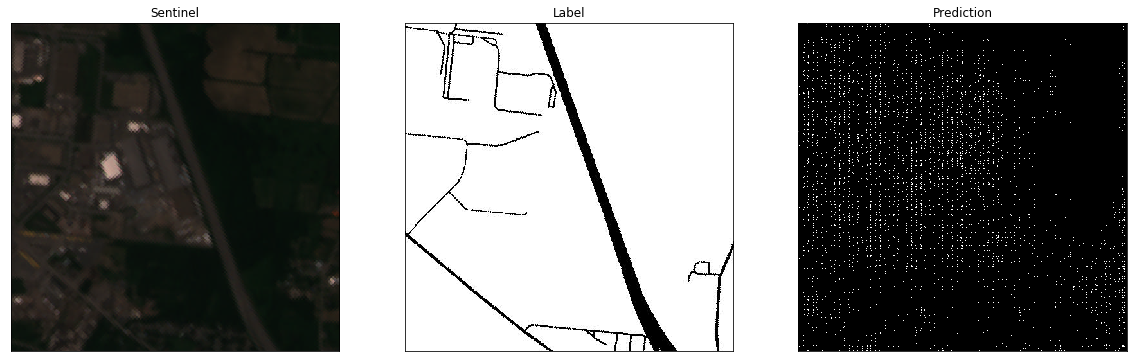

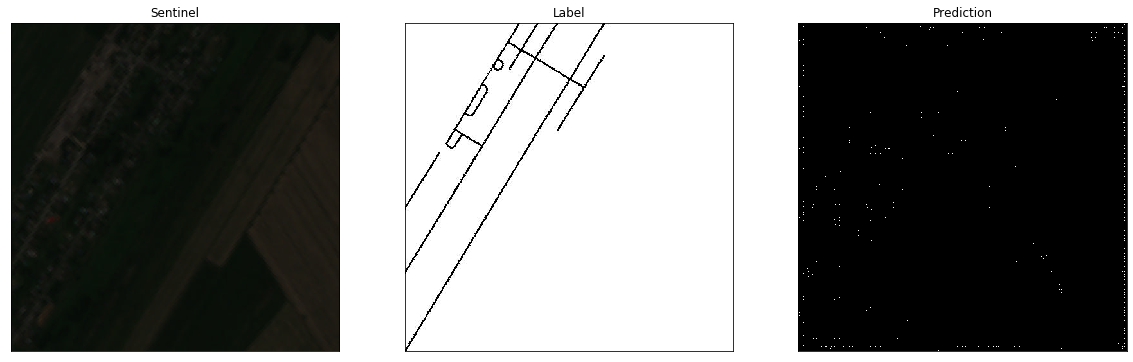

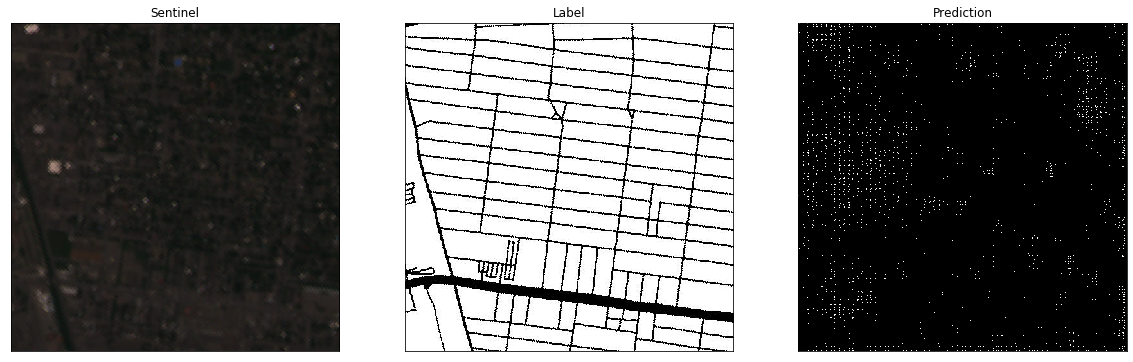

In [7]:
matplotlib.rcParams['figure.figsize'] = [20, 20]
subgraph_rem = 2

for i in range(limit):
    res = [idx for idx in image_file_list if idx.startswith("{}_".format(i))]
    f,ax = plt.subplots(1,subgraph_count, gridspec_kw={'width_ratios': width_ratio})
    for file in res:
        if "predict" in file and "_1." in file:
            predict = mpimg.imread('{}images/{}'.format(working_path, file))
            predict = predict < 0.5           
            predict = predict.astype(int)
            ax[2].imshow(predict, cmap="gray")
            ax[2].set_title("Prediction")
        
        elif "B02" in file:
            # blue
            blue = mpimg.imread('{}images/{}'.format(working_path, file))
        
        elif "B03" in file:
            # green
            green = mpimg.imread('{}images/{}'.format(working_path, file))
        
        elif "B04" in file:
            # red
            red = mpimg.imread('{}images/{}'.format(working_path, file))
        
        elif "label" in file and "_0_0." in file:
            # label
            label = mpimg.imread('{}images/{}'.format(working_path, file))
            ax[1].imshow(label, cmap="gray")
            ax[1].set_title("Label")
            
        elif "traj_count" in file:
            subgraph_rem += 1
            traj_count = mpimg.imread('{}images/{}'.format(working_path, file))
            ax[subgraph_rem].imshow(traj_count, cmap="gray")
            ax[subgraph_rem].set_title("Trajectory Density")
        
        elif "speed_max" in file:
            subgraph_rem += 1
            speed_max = mpimg.imread('{}images/{}'.format(working_path, file))
            ax[subgraph_rem].imshow(speed_max, cmap="gray")
            ax[subgraph_rem].set_title("Maximum speed")
        
        elif "speed_avg" in file:
            subgraph_rem += 1
            speed_avg = mpimg.imread('{}images/{}'.format(working_path, file))
            ax[subgraph_rem].imshow(speed_avg, cmap="gray")
            ax[subgraph_rem].set_title("Average speed")
            
    sentinel_img = np.dstack((red, green, blue))
    ax[0].imshow(sentinel_img, cmap="magma")
    ax[0].set_title("Sentinel")
  
    for x in ax:
        x.set_xticks([])
        x.set_yticks([])
        
    if label.mean() == 255.:
        print("Label image patch doesn't contain any road.")
    
    plt.show()
    subgraph_rem = 2